In [27]:
# # !pip install wordcloud
# !pip install emoji
# # !pip install xgboost
# !pip install ekphrasis -U
# # !pip install gensim
# !pip install catboost

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer


import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score


#from sklearn.feature_extraction.review import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import emoji
import regex as re

import json
import pandas as pd
import glob
import spacy
import nltk

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from transformers import BertTokenizer, BertModel
import torch
import glob

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [29]:
import warnings
warnings.filterwarnings("ignore")

# Download dataset

First off, we downloaded tweet topic classification dataset from huggingface.co and removed duplicating texts.

In [30]:
!git clone https://huggingface.co/datasets/cardiffnlp/tweet_topic_single

fatal: destination path 'tweet_topic_single' already exists and is not an empty directory.


In [31]:
texts = []
dates = []
labels = []
ids = []
label_names = []

files = glob.glob('tweet_topic_single/dataset/*/*.json')

for file in files:
    with open(file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tweet = json.loads(line)
        texts.append(tweet['text'])
        labels.append(tweet['label'])
        label_names.append(tweet['label_name'])

tweets_df = pd.DataFrame({"texts": texts, "labels": labels, "label_names": label_names})
data = tweets_df
data.head()

,texts,labels,label_names
0,Jalen hurts first drive low key lookin really ...,4,sports_&_gaming
1,Sometimes The Bad Things That Happen In Our Li...,3,daily_life
2,I request all the country men to give holiday...,3,daily_life
3,Quicker end than expected. Had a blast {@USA S...,4,sports_&_gaming
4,The first #musicofthefuturevideooftheweek is n...,2,pop_culture


In [32]:
data.drop_duplicates(subset='texts', inplace=True)
data

,texts,labels,label_names
0,Jalen hurts first drive low key lookin really ...,4,sports_&_gaming
1,Sometimes The Bad Things That Happen In Our Li...,3,daily_life
2,I request all the country men to give holiday...,3,daily_life
3,Quicker end than expected. Had a blast {@USA S...,4,sports_&_gaming
4,The first #musicofthefuturevideooftheweek is n...,2,pop_culture
...,...,...,...
6992,Did we learn more about the {@Buffalo Bills@} ...,4,sports_&_gaming
6993,#IntroduceYourDad TRUE STORY All of my younge...,3,daily_life
6994,I’m so confused about the piece I just watched...,2,pop_culture
6995,A Special Place In Hell by Reid Henry {{URL}} ...,2,pop_culture


# EDA

Overall, we have 6996 texts in the dataset with `sports_&_gaming`, `daily_life`, `pop_culture` being dominating topics. \
At the same time `arts_&_culture`, `science_&_technology` and `business_&_entrepreneurs` have less than 500 tweets.

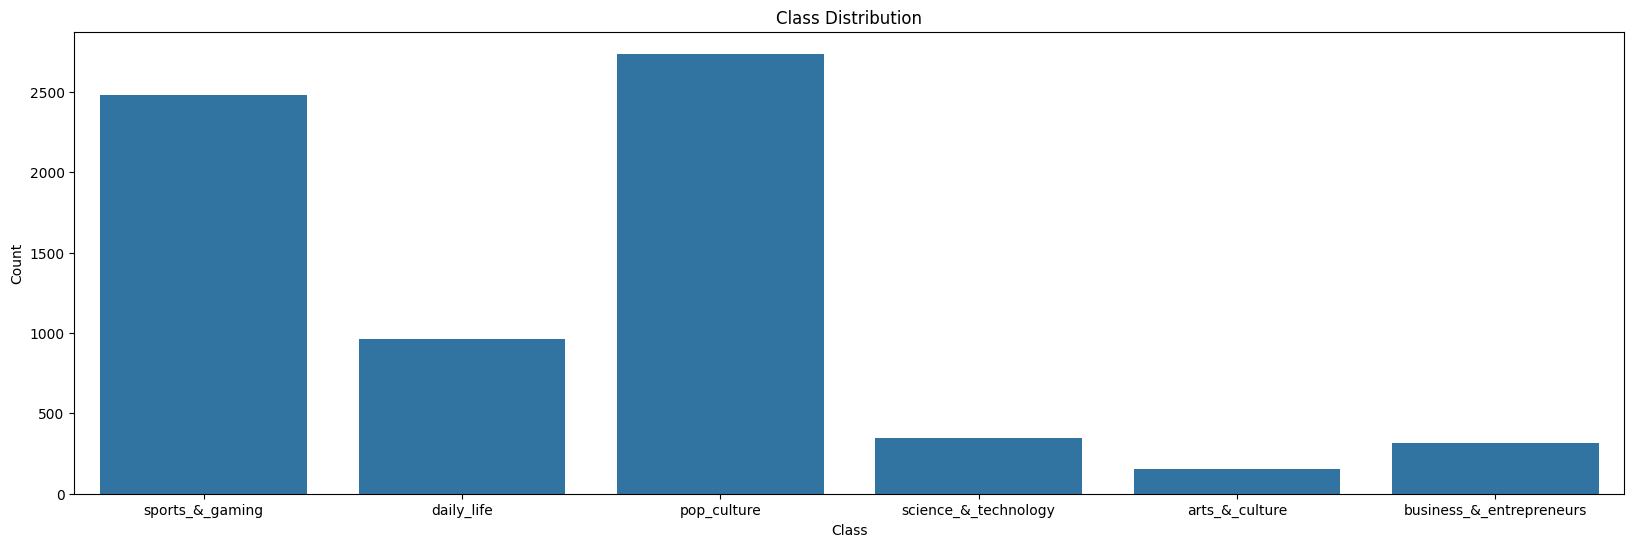

In [33]:
# Class distribution
plt.figure(figsize=(20,6))
sns.countplot(data=data, x='label_names')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Length of tweets cannot help us to idntify the topic, for most tweets it is from 50 to 300 words. Only for the greatest topics in size, prevalence of shorter texts is notable.

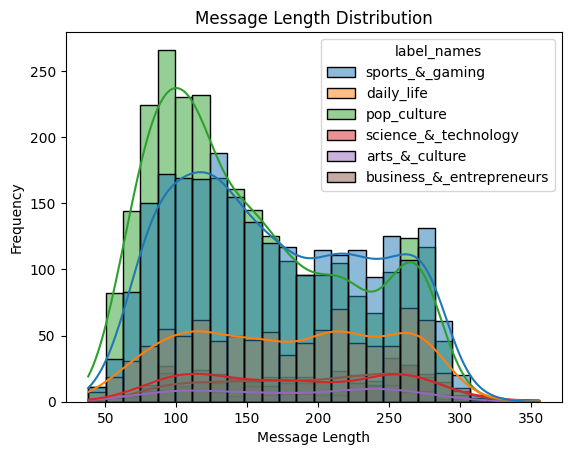

In [34]:
# Message Length Distribution according to the target value
data['text_length'] = data['texts'].apply(len)
sns.histplot(data=data, x='text_length', hue='label_names', kde=True)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

Word clouds show that URL and USERNAME meet often, however, they are not helpful for analysis. They represent links and usernames, but we have no knowledge about their relationship to the topic. Also, inside each word cloud some words appear several times, thus, some preprocessing is needed.

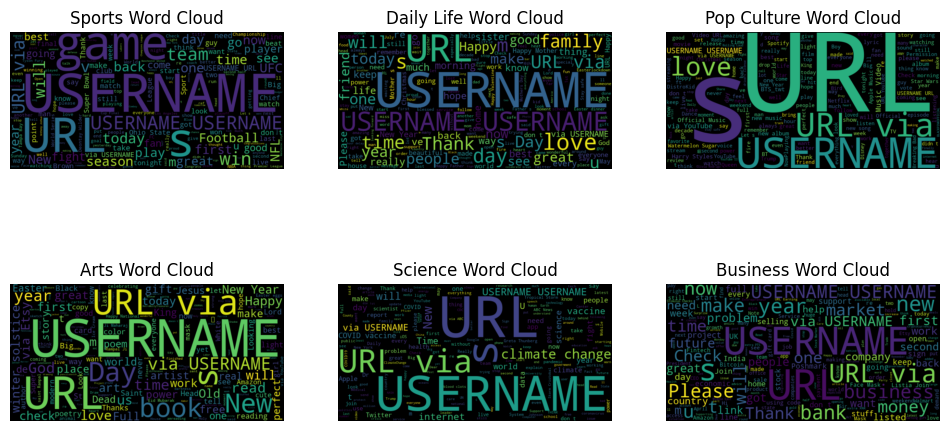

In [35]:
# WordClouds for targets
sports = ' '.join(data[data['label_names'] == 'sports_&_gaming']['texts'])
daily = ' '.join(data[data['label_names'] == 'daily_life']['texts'])
pop_culture = ' '.join(data[data['label_names'] == 'pop_culture']['texts'])
arts = ' '.join(data[data['label_names'] == 'arts_&_culture']['texts'])
science = ' '.join(data[data['label_names'] == 'science_&_technology']['texts'])
business = ' '.join(data[data['label_names'] == 'business_&_entrepreneurs']['texts'])

sports_wordcloud = WordCloud(width=800, height=400).generate(sports)
daily_wordcloud = WordCloud(width=800, height=400).generate(daily)
pop_culture_wordcloud = WordCloud(width=800, height=400).generate(pop_culture)
arts_wordcloud = WordCloud(width=800, height=400).generate(arts)
science_wordcloud = WordCloud(width=800, height=400).generate(science)
business_wordcloud = WordCloud(width=800, height=400).generate(business)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(sports_wordcloud, interpolation='bilinear')
plt.title('Sports Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(daily_wordcloud, interpolation='bilinear')
plt.title('Daily Life Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pop_culture_wordcloud, interpolation='bilinear')
plt.title('Pop Culture Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(arts_wordcloud, interpolation='bilinear')
plt.title('Arts Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(science_wordcloud, interpolation='bilinear')
plt.title('Science Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(business_wordcloud, interpolation='bilinear')
plt.title('Business Word Cloud')
plt.axis('off')

plt.show()

# Data Preprocessing

The following function allows to:
1) Change all capital letters to lowercase letters
2) Repalce common categories like phone, email by respective words
3) Split hashtags into several words
4) Correct spelling mistakes

In [36]:
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

def prep(text):
    return " ".join(text_processor.pre_process_doc(text))

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [37]:
data['texts'] = data['texts'].apply(prep)

## Lemmatization
Lemmatization was used to reduce word to its root form

In [38]:
def lemmatization(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token)
    return " ".join([token.lemma_ for token in doc])

In [39]:
nlp = spacy.load('en_core_web_sm')

In [40]:
data['texts'] = data['texts'].apply(lemmatization)

In [41]:
data

,texts,labels,label_names,text_length
0,jalen hurt first drive low key lookin really g...,4,sports_&_gaming,99
1,sometimes the bad thing that happen in our lif...,3,daily_life,163
2,I request all the country man to give holiday ...,3,daily_life,241
3,quick end than expect . have a blast { < user ...,4,sports_&_gaming,125
4,the first music of the future video of the wee...,2,pop_culture,210
...,...,...,...,...
6992,do we learn more about the { < user > bill @ }...,4,sports_&_gaming,298
6993,introduce your dad true story all of my young ...,3,daily_life,161
6994,I ' m so confused about the piece I just watch...,2,pop_culture,215
6995,a special place in hell by reid henry { { url ...,2,pop_culture,155


## Removing stop words

In [42]:
def stop_words(texts):
    stop_words = set(stopwords.words('english'))
    regex = re.compile('[^a-zA-Z]')
    preprocess_texts = []
    for text in tqdm(texts):
        text = text.lower()
        text = regex.sub(' ', text)
        word_tokens = nltk.word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if (w not in stop_words) & (w != 'url')  & (w != 'username') & (w != 'via')
                             & (w != 'ha') & (w != 'user')  & (w != 'number')& (w != 'love') & (w != 'time')]

        processed = []
        for word in filtered_sentence:
            word = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', word)
            word = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress', word)
            word = re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr', word)
            processed.append(word)

        preprocess_texts.append(' '.join(processed))

    return preprocess_texts

In [43]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayyaspirina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mayyaspirina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
data['texts'] = stop_words(data['texts'])
data['texts']

100%|████████████████████████████████████████████████████████████████████████████████████| 6996/6996 [00:01<00:00, 5214.03it/s]


0       jalen hurt first drive low key lookin really g...
1       sometimes bad thing happen life put directly g...
2       request country man give holiday servant work ...
3       quick end expect blast softball girl coach tea...
4       first music future video week live feature wat...
                              ...                        
6992    learn bill england patriot yesterday patriot a...
6993    introduce dad true story young cousin side als...
6994    confused piece watch sunday morning erin moria...
6995    special place hell reid henry play check amazi...
6996    idk man respect artist human one hardworking p...
Name: texts, Length: 6996, dtype: object

Now word clouds are representable with relevant most common words.

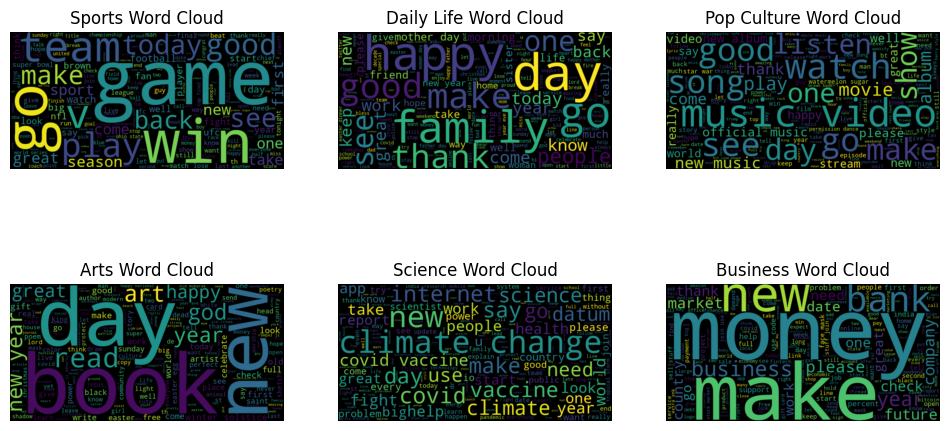

In [45]:
# WordClouds after preprocessing
sports = ' '.join(data[data['label_names'] == 'sports_&_gaming']['texts'])
daily = ' '.join(data[data['label_names'] == 'daily_life']['texts'])
pop_culture = ' '.join(data[data['label_names'] == 'pop_culture']['texts'])
arts = ' '.join(data[data['label_names'] == 'arts_&_culture']['texts'])
science = ' '.join(data[data['label_names'] == 'science_&_technology']['texts'])
business = ' '.join(data[data['label_names'] == 'business_&_entrepreneurs']['texts'])

sports_wordcloud = WordCloud(width=800, height=400).generate(sports)
daily_wordcloud = WordCloud(width=800, height=400).generate(daily)
pop_culture_wordcloud = WordCloud(width=800, height=400).generate(pop_culture)
arts_wordcloud = WordCloud(width=800, height=400).generate(arts)
science_wordcloud = WordCloud(width=800, height=400).generate(science)
business_wordcloud = WordCloud(width=800, height=400).generate(business)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(sports_wordcloud, interpolation='bilinear')
plt.title('Sports Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(daily_wordcloud, interpolation='bilinear')
plt.title('Daily Life Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pop_culture_wordcloud, interpolation='bilinear')
plt.title('Pop Culture Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(arts_wordcloud, interpolation='bilinear')
plt.title('Arts Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(science_wordcloud, interpolation='bilinear')
plt.title('Science Word Cloud')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(business_wordcloud, interpolation='bilinear')
plt.title('Business Word Cloud')
plt.axis('off')

plt.show()

# Split data

Use stratified train_test_split to have similar proportions of tweets in both test and train

In [46]:
X = data.texts
y = data.labels

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Word Embeddings

## TF-IDF
It is commented, as TF-IDF leads to worse performance on our dataset

In [48]:
# tfidf = TfidfVectorizer()

In [49]:
# X_train = tfidf.fit_transform(X_train).toarray()
# X_test = tfidf.transform(X_test).toarray()

## Word2Vec

Let us see existing pretrained models for converting words to its vector embeddings

We compare models trained on different corpora to study how the choice affects performance. Our hypothesis is that glove-twitter-200 is the best choice for tweet classification

In [50]:
glove_twitter_model = api.load("glove-twitter-100")

In [51]:
def vectorize(sentence, model):
    words = sentence.split()
    words_vecs = [model[word] for word in words if word in model]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_glove_twitter = np.array([vectorize(sentence, glove_twitter_model) for sentence in X_train])
X_test_glove_twitter = np.array([vectorize(sentence, glove_twitter_model) for sentence in X_test])

# LSTM

In [55]:
import torch.nn.functional as F
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn

In [52]:
def confusion_mat(y_test, pred):
    matrix = confusion_matrix(y_test, pred)
    plt.figure()
    sns.set()
    sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, cmap="OrRd")
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

In [85]:
X_train, X_test, y_train, y_test = train_test_split(data.texts, data.labels, test_size=0.2, random_state=42, stratify=y)

In [86]:
batch_size = 16

tokenizer = Tokenizer(num_words=len(X_train_glove_twitter))
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=750)
X_val = pad_sequences(X_val, maxlen=750)

X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_test.tolist(), dtype=torch.long)

train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=False)

In [92]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(len(X_train_glove_twitter), len(X_train_glove_twitter[0]))
        self.embedding.weight = nn.Parameter(torch.tensor(X_train_glove_twitter, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(len(X_train_glove_twitter[0]), 64, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(256 , 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(128, 6)

    def forward(self, x):
        embed_layer = self.embedding(x)
        lstm_layer, _ = self.lstm(embed_layer)
        avg_pool = torch.mean(lstm_layer, 1)
        max_pool, _ = torch.max(lstm_layer, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        # conc = self.dropout(conc)
        # conc = self.relu(self.linear2(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [93]:
num_epochs = 5
model = BiLSTM()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device) 


for epoch in range(num_epochs):

    model.train()
    for i, (x_batch, y_batch) in enumerate(train_dataloader):
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()        
    val_loss = 0
    val_preds = np.zeros((len(X_test), 6))
    for i, (x_batch, y_batch) in enumerate(val_dataloader):
        y_pred = model(x_batch).detach()
        val_loss += criterion(y_pred, y_batch).item() / len(val_dataloader)
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()
    print(sum(val_preds.argmax(axis=1)==y_test)/len(y_test))
    print('Epoch {}/{}  \t val_loss={:.4f} '.format(epoch + 1, num_epochs, val_loss))

0.5042857142857143
Epoch 1/5  	 val_loss=20.5871 
0.5871428571428572
Epoch 2/5  	 val_loss=17.1637 
0.6421428571428571
Epoch 3/5  	 val_loss=15.7988 
0.6592857142857143
Epoch 4/5  	 val_loss=14.6932 
0.6635714285714286
Epoch 5/5  	 val_loss=14.5549 


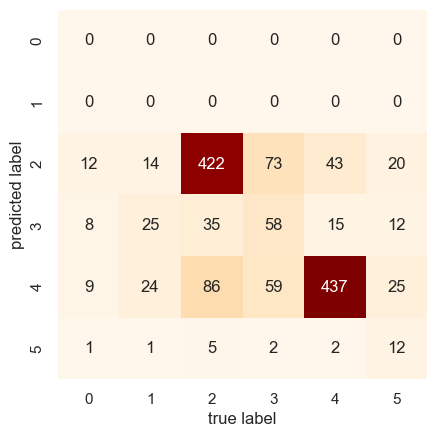

In [94]:
y_pred = val_preds.argmax(axis=1)
confusion_mat(y_test, y_pred)

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        64
           2       0.72      0.77      0.75       548
           3       0.38      0.30      0.34       192
           4       0.68      0.88      0.77       497
           5       0.52      0.17      0.26        69

    accuracy                           0.66      1400
   macro avg       0.38      0.35      0.35      1400
weighted avg       0.60      0.66      0.62      1400

